In [1]:
import pandas as pd
import numpy as np
import os.path
from sklearn.feature_extraction.text import CountVectorizer
import pickle as pkl
from time import time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import ParameterGrid
from random import sample
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import ensemble, preprocessing, metrics

In [2]:
# Load data with label
data201511 = pd.read_csv("small_2015-11_key_word.csv",index_col=False, header=None)
data201511.columns = np.array([str(i) for i in data201511.columns.values])
data201506 = pd.read_csv("small_2015-06_key_word.csv",index_col=False, header=None)
data201506.columns = np.array([str(i) for i in data201506.columns.values])

In [3]:
data2015 =  pd.concat([data201506, data201511])
data2015 = data2015[data2015['1'].notnull()]
data2015.groupby(data2015['4']).size()

4
0    8610183
1     491745
2     413578
3      19987
dtype: int64

In [4]:
# The column 4 is label, 
# when 0 means no mention to foods or activity, 1 means mention food , 
# 2 means mention activity and 3 means both are mentioned
data2015.head()

,0,1,2,3,4
0,611053325644005376,she say unenthused,NaN,NaN,0
1,611162865551192064,for ailment sun remedy none if try find,NaN,NaN,0
2,611058983927836673,yeah rest conditioning summer,NaN,NaN,0
3,611165766952591360,remind blessed i walk office today,NaN,walk,2
4,611159320655347712,unarmed white teen shot black officer,NaN,NaN,0


In [5]:
data2015_0 = data2015[data2015['4']==0]
data2015_0_balanced = data2015_0.sample(512000)
data2015_food = data2015[(data2015['4']==1) | (data2015['4']==3) ]

In [6]:
data_model = pd.concat([data2015_0_balanced, data2015_food])
data_model =data_model.sample(frac=1).reset_index(drop=True)

In [7]:
data_model = data_model.drop(['2','3'],axis = 1)
data_model.columns = ['TweetsID','Tokenized_text','label']
data_model = data_model.replace(3,1)
data_model.groupby('label').size()

label
0    512000
1    511732
dtype: int64

In [116]:
data_model.head()

,TweetsID,Tokenized_text,label
1,665927661982769153,sanctuary s factor new york ny,0
2,671410577214939136,when client place style know have teach,0
3,615675179671396352,you not eat ice cream day melt but eat ice cream,1
4,666355191134990336,good morning san diegoooo course german mean w...,1
5,605421100395311104,flower lay site amtrak car collision morning c...,1


In [8]:
length = [len(data_model.Tokenized_text.iloc[i].split()) for i in range(len(data_model))]
length.sort()

In [9]:
import collections
collections.Counter(length)
dict_len = dict(collections.Counter(length))

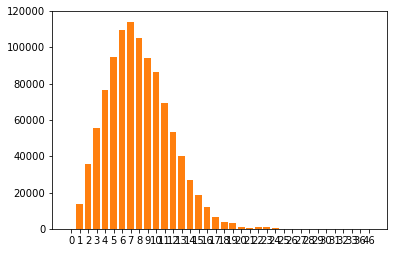

In [12]:
from matplotlib import pyplot as plt
plt.bar(range(len(dict_len)), list(dict_len.values()), align='center')
plt.xticks(range(len(dict_len)), list(dict_len.keys()))
plt.show()

In [10]:
# Only keep tokenized text of lengths more than 4
idx = [i for i in range(len(data_model)) if len(data_model.Tokenized_text.iloc[i].split()) >=5]
data_model = data_model.iloc[idx]

In [11]:
len(data_model)

842334

In [38]:
data_model.groupby('label').size()

label
0    382502
1    459561
dtype: int64

In [26]:
def loading_lda(num_topics,max_features,max_df,min_df,data_model):
    tf_path = 'saved_model_{}/tfVectorizer_topics={}_maxFeatures={}_maxDf={}_minDf={}.pickle'.format(num_topics,num_topics,max_features,max_df,min_df)
    lda_path = 'saved_model_{}/LDA_topics={}_maxFeatures={}_maxDf={}_minDf={}.pickle'.format(num_topics, num_topics,max_features,max_df,min_df)
    if (os.path.exists(tf_path)) & ( os.path.exists(lda_path)):
        with open(tf_path,'rb') as input_file:
            tf_vectorizer = pkl.load(input_file)
        with open(lda_path, "rb") as input_file:
            lda = pkl.load(input_file)
        prob_arr = lda.transform(tf_vectorizer.transform(data_model['Tokenized_text']))
        new_cols = ['topics_{}'.format(i+1) for i in range(num_topics)]
        new_vals = [list(prob_arr[i]) for i in range(len(data_model))]
        data_ft = data_model.reindex(columns=data_model.columns.tolist() + new_cols)   # add empty cols
        data_ft[new_cols] = new_vals 
        X = data_ft[['topics_{}'.format(i+1) for i in range(num_topics)]]
        y = data_ft.label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        clf = ensemble.RandomForestClassifier(random_state=0)
        clf.fit(X_train, y_train)
        y_test_predicted = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_test_predicted)
    else:
        print('The file doesn\'t exist')
        accuracy = 0
    return accuracy

In [57]:
food = list(pkl.load(open("food.pickle","rb")))
food = [i.strip() for i in food]
activity = list(pkl.load(open("activity.pickle","rb")))
activity = [i.strip() for i in activity]

In [61]:
from matplotlib import pyplot as plt

In [113]:
def lda_plots(num_topics,max_features):
    tf_path = 'saved_model_{}/tfVectorizer_topics={}_maxFeatures={}_maxDf=0.4_minDf=1.pickle'.format(num_topics,num_topics,max_features)
    lda_path = 'saved_model_{}/LDA_topics={}_maxFeatures={}_maxDf=0.4_minDf=1.pickle'.format(num_topics, num_topics,max_features)
    if (os.path.exists(tf_path)) & ( os.path.exists(lda_path)):
        with open(tf_path,'rb') as input_file:
            tf_vectorizer = pkl.load(input_file)
        with open(lda_path, "rb") as input_file:
            LDA = pkl.load(input_file)
        food_freq_list = []
        activity_freq_list = []
        combine_freq_list = []

        for i in range(len(LDA.components_)):
            prob = LDA.components_[i] / LDA.components_.sum(axis=1)[:, np.newaxis][i]
            top_words_idx = np.where(prob > 0.0001)[0]
            top_words = [tf_vectorizer.get_feature_names()[j] for j in top_words_idx]
            food_freq = sum([word in food for word in top_words])/len(top_words)
            food_freq_list.append(food_freq)
            activity_freq = sum([word in activity for word in top_words])/len(top_words)
            activity_freq_list.append(activity_freq)
            combine_freq = food_freq + activity_freq
            combine_freq_list.append(combine_freq)
            
        fig = plt.figure(figsize=(30,20))
        plt.plot(food_freq_list, label = 'food',color='blue', marker='o')
        plt.plot(activity_freq_list,label='activity',color='red',marker = 'o')
        plt.plot(combine_freq_list,label = 'both',color='green',marker = 'o' )
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 24)
        #ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)

        plt.title("Frequency Distribution over Topics{} Max Features {}".format(num_topics,max_features),fontsize=40)
        plt.xlabel("ith topic",fontsize=40)
        plt.ylabel('Frequency',fontsize=40)
        plt.legend(prop={'size': 26})
        
        plt.savefig('figures/topics_{}_maxfeatures_{}.png'.format(num_topics, max_features))
    else:
        print('The file topics_{}_maxfeatures_{} doesn.t exist'.format(num_topics, max_features))
        
    return 
        
                    
                


In [24]:
from sklearn.model_selection import ParameterGrid
grid = {'num_topics':[25,50,75,100],
           'max_features':[12000,16000],
           'max_df':[0.4,0.5,0.6],
           'min_df':[1]}
comb = list(ParameterGrid(grid))
for para in comb:
    print(para)
    break

{'max_df': 0.4, 'max_features': 12000, 'min_df': 1, 'num_topics': 25}


In [128]:
grid3 = {'num_topics':[100],
           'max_features':[20000,25000],
           'max_df':[0.5,0.75],
           'min_df':[1]}
comb3 = list(ParameterGrid(grid3))

In [130]:
ft2 = []
acc2 = []
for para in comb3:
    ft2.append('topics_{}_maxfeatures_{}_maxdf_{}'.format(para['num_topics'], para['max_features'], para['max_df']))
    acc2.append(loading_lda(para['num_topics'], para['max_features'], para['max_df'], para['min_df'],data_model))

In [ ]:
df_acc2 = pd.DataFrame({'Model_Conf': ft2, 'Accuracy': acc2})

In [138]:
ft3 = []
acc3 = []
ft3.append('topics_125_maxfeatures_20000_maxdf_0.5')
acc3.append(loading_lda(125, 20000, 0.5, 100,data_model))

In [139]:
ft3.append('topics_125_maxfeatures_25000_maxdf_0.5')
acc3.append(loading_lda(125, 25000, 0.5, 100,data_model))

In [140]:
df_acc3 = pd.DataFrame({'Model_Conf': ft3, 'Accuracy': acc3})

In [ ]:
ft = []
acc = []
for para in comb:
    ft.append('topics_{}_maxfeatures_{}_maxdf_{}'.format(para['num_topics'], para['max_features'], para['max_df']))
    acc.append(loading_lda(para['num_topics'], para['max_features'], para['max_df'], para['min_df'],data_model))

In [31]:
df_acc = pd.DataFrame({'Model_Conf': ft, 'Accuracy': acc})

In [134]:
df_acc = df_acc.append(df_acc2, ignore_index=True)

In [141]:
df_acc = df_acc.append(df_acc3, ignore_index=True)

In [142]:
df_acc = df_acc[['Model_Conf','Accuracy']]
df_acc.sort_values(['Accuracy'], ascending = False)

,Model_Conf,Accuracy
29,topics_125_maxfeatures_25000_maxdf_0.5,0.747025
28,topics_125_maxfeatures_20000_maxdf_0.5,0.745582
7,topics_100_maxfeatures_16000_maxdf_0.4,0.740317
23,topics_100_maxfeatures_16000_maxdf_0.6,0.740317
15,topics_100_maxfeatures_16000_maxdf_0.5,0.740317
27,topics_100_maxfeatures_25000_maxdf_0.75,0.739361
25,topics_100_maxfeatures_25000_maxdf_0.5,0.739361
26,topics_100_maxfeatures_20000_maxdf_0.75,0.738536
24,topics_100_maxfeatures_20000_maxdf_0.5,0.738536
11,topics_100_maxfeatures_12000_maxdf_0.5,0.736536


In [115]:
df_acc.to_csv('RF Accuracy.csv')

In [55]:
df_acc.at[20, 'Accuracy']  = loading_lda(25,16000,0.6,1,data_model)
#df_acc.iloc[22]['Accuracy'] = loading_lda(75,16000,0.6,1,data_model)

In [114]:
grid2 = {'num_topics':[25,50,75,100],
           'max_features':[12000,16000]}
comb2 = list(ParameterGrid(grid2))
for para in comb2:
    lda_plots(para['num_topics'], para['max_features'])

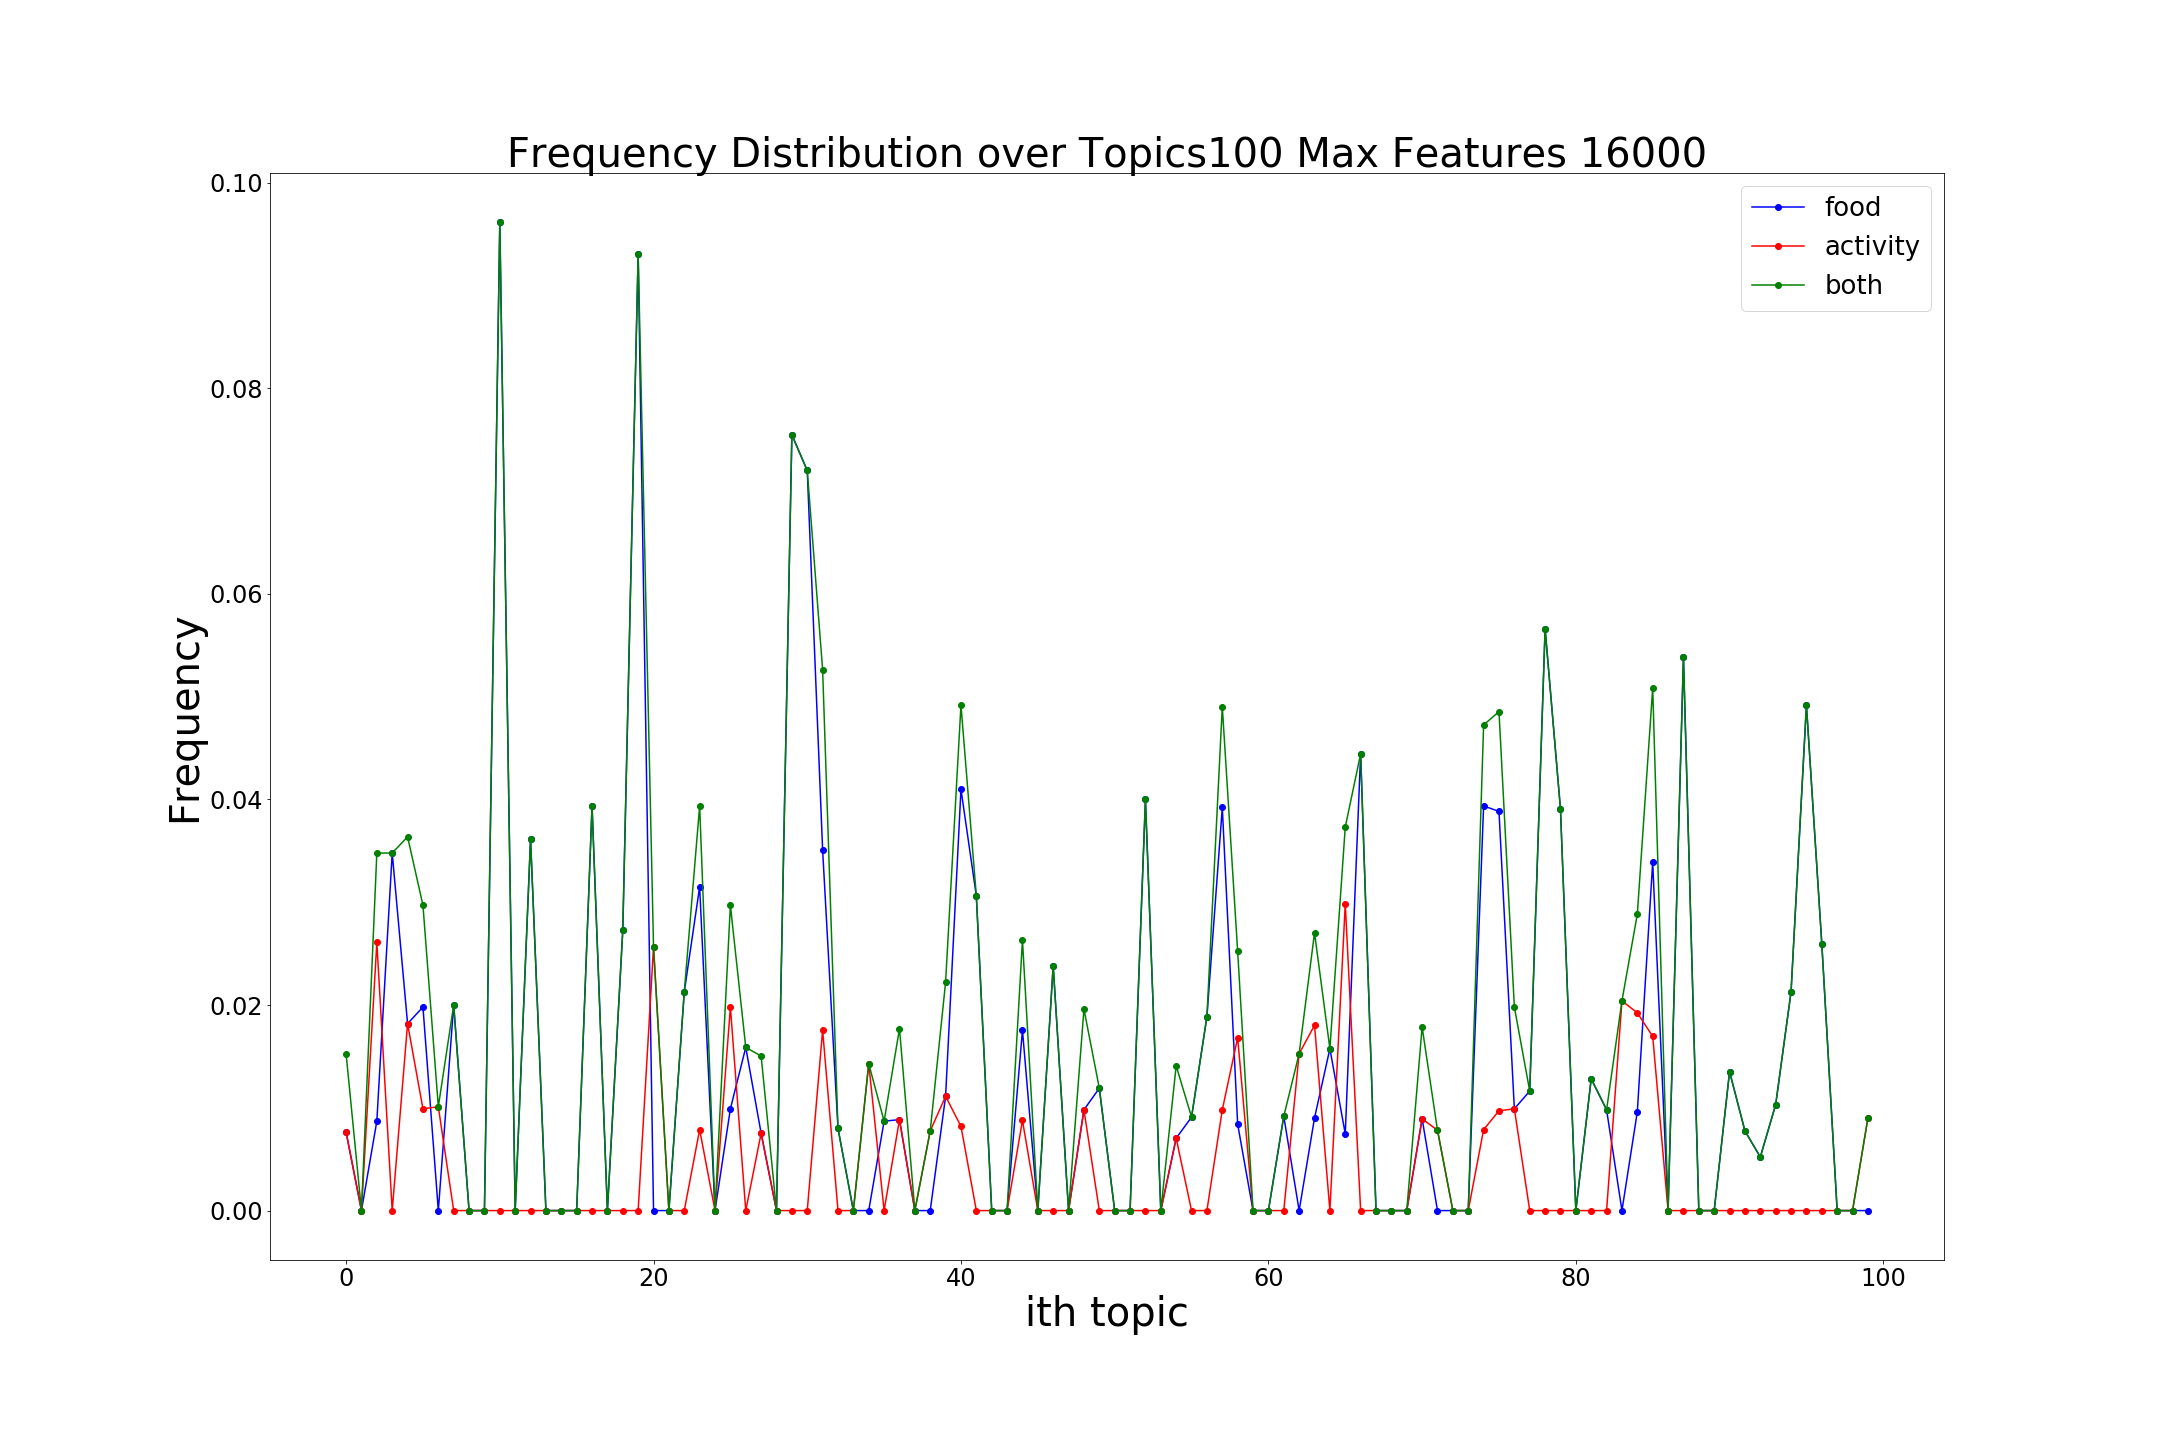

In [123]:
from IPython.display import Image 
Image(filename='figures/topics_100_maxfeatures_16000.png')

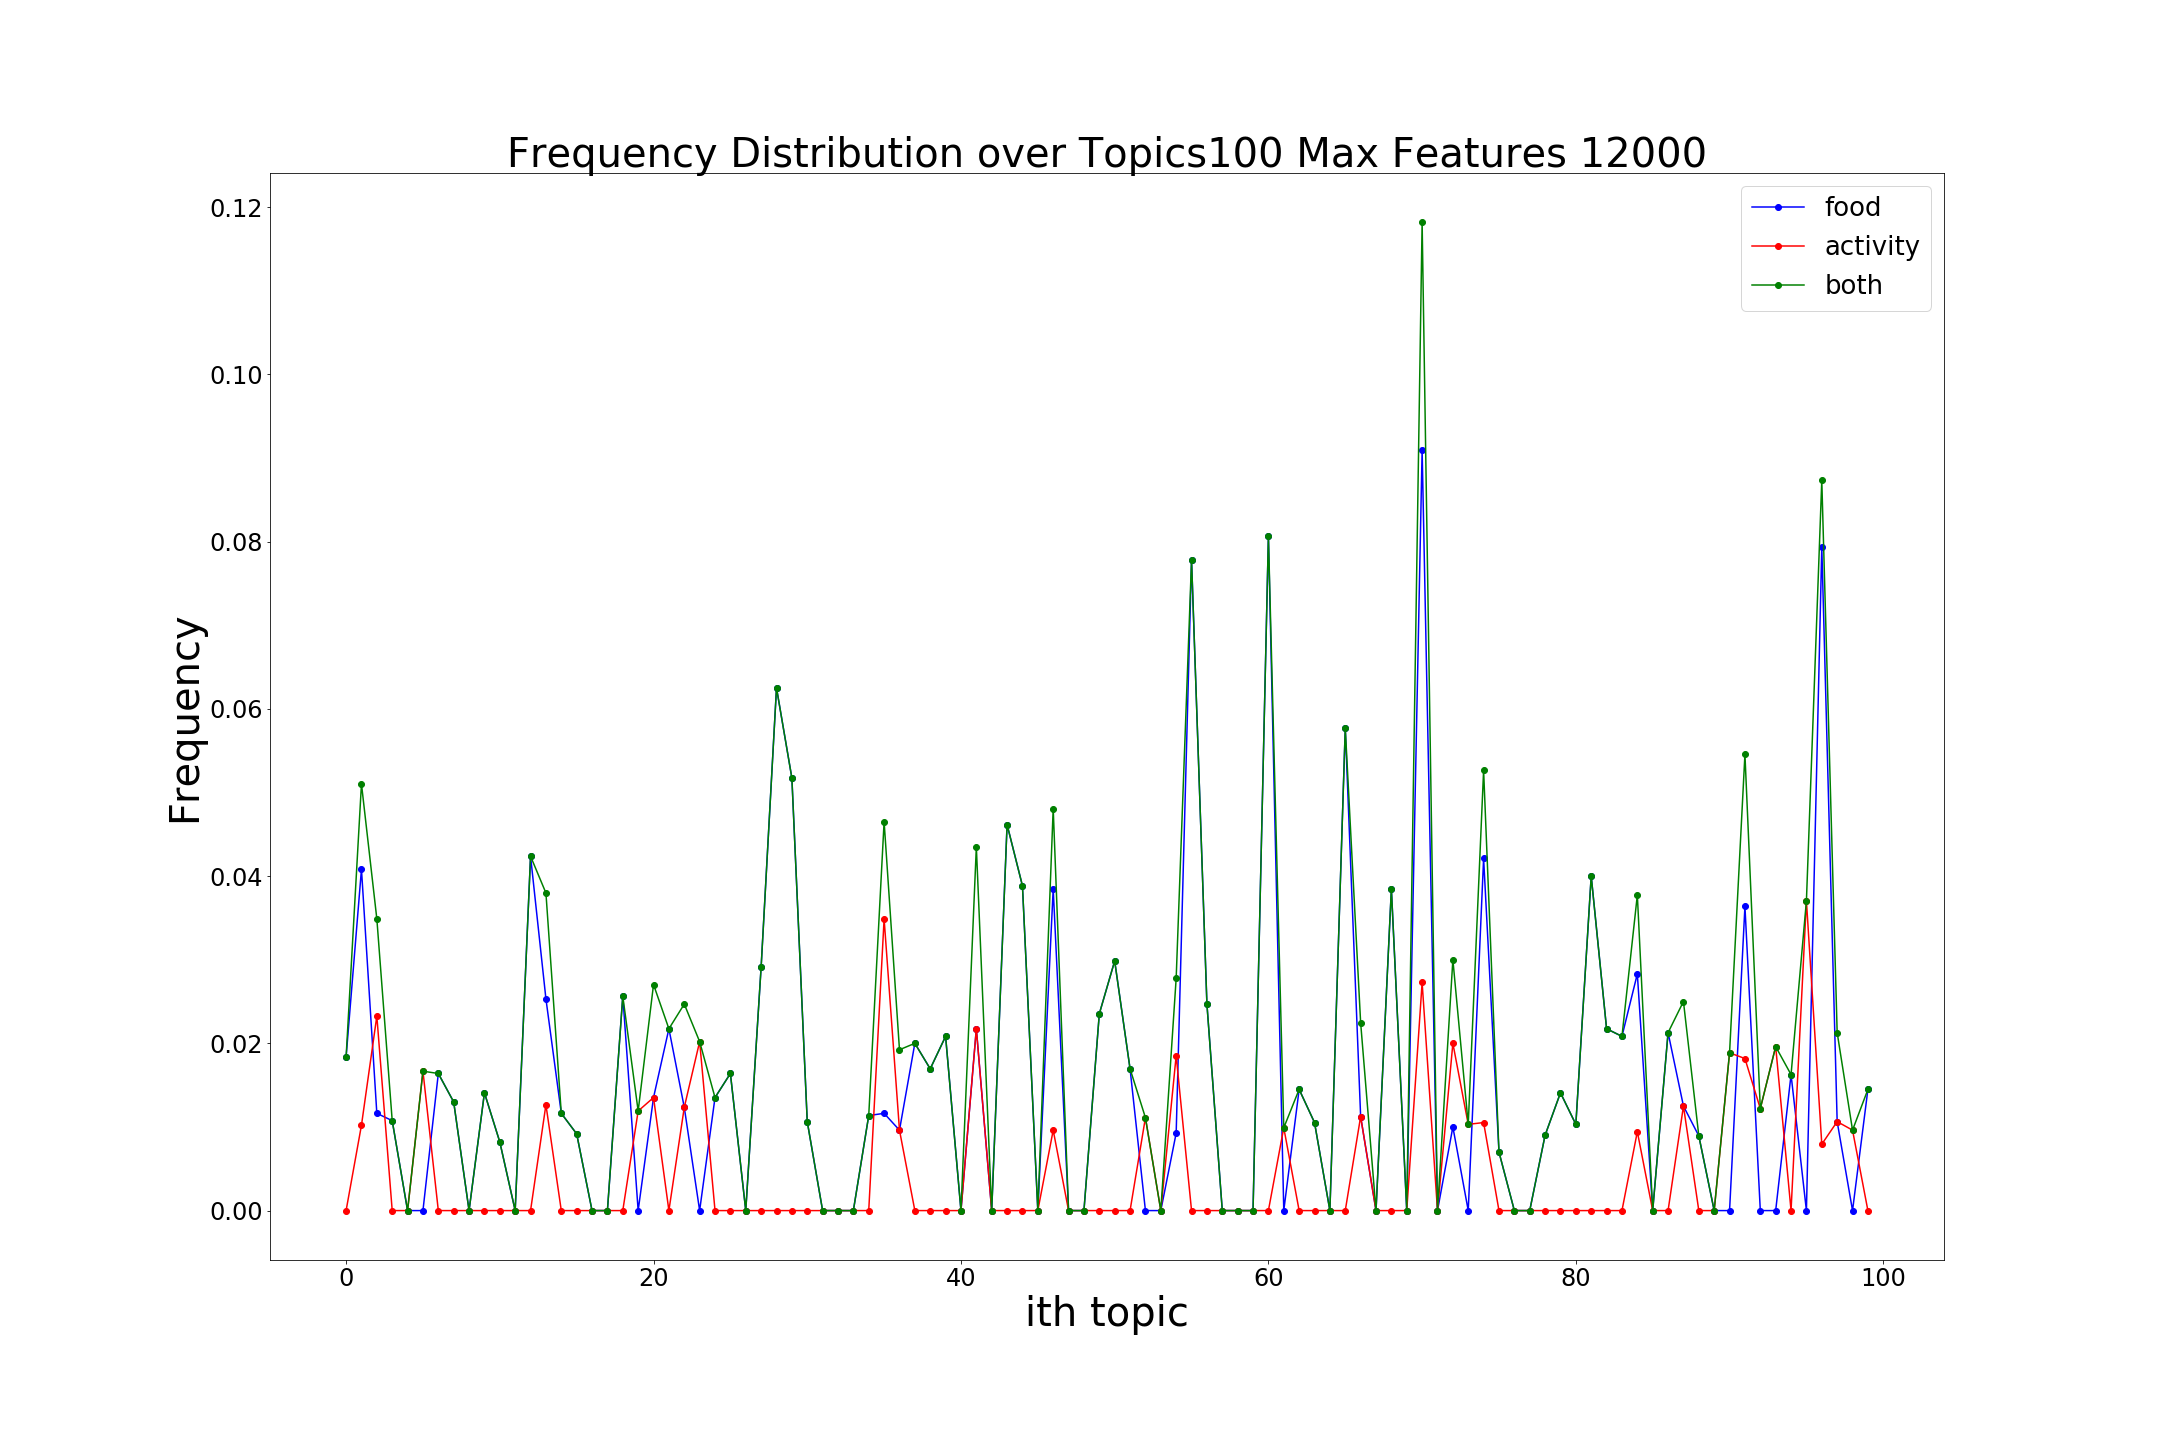

In [124]:
Image(filename='figures/topics_100_maxfeatures_12000.png')

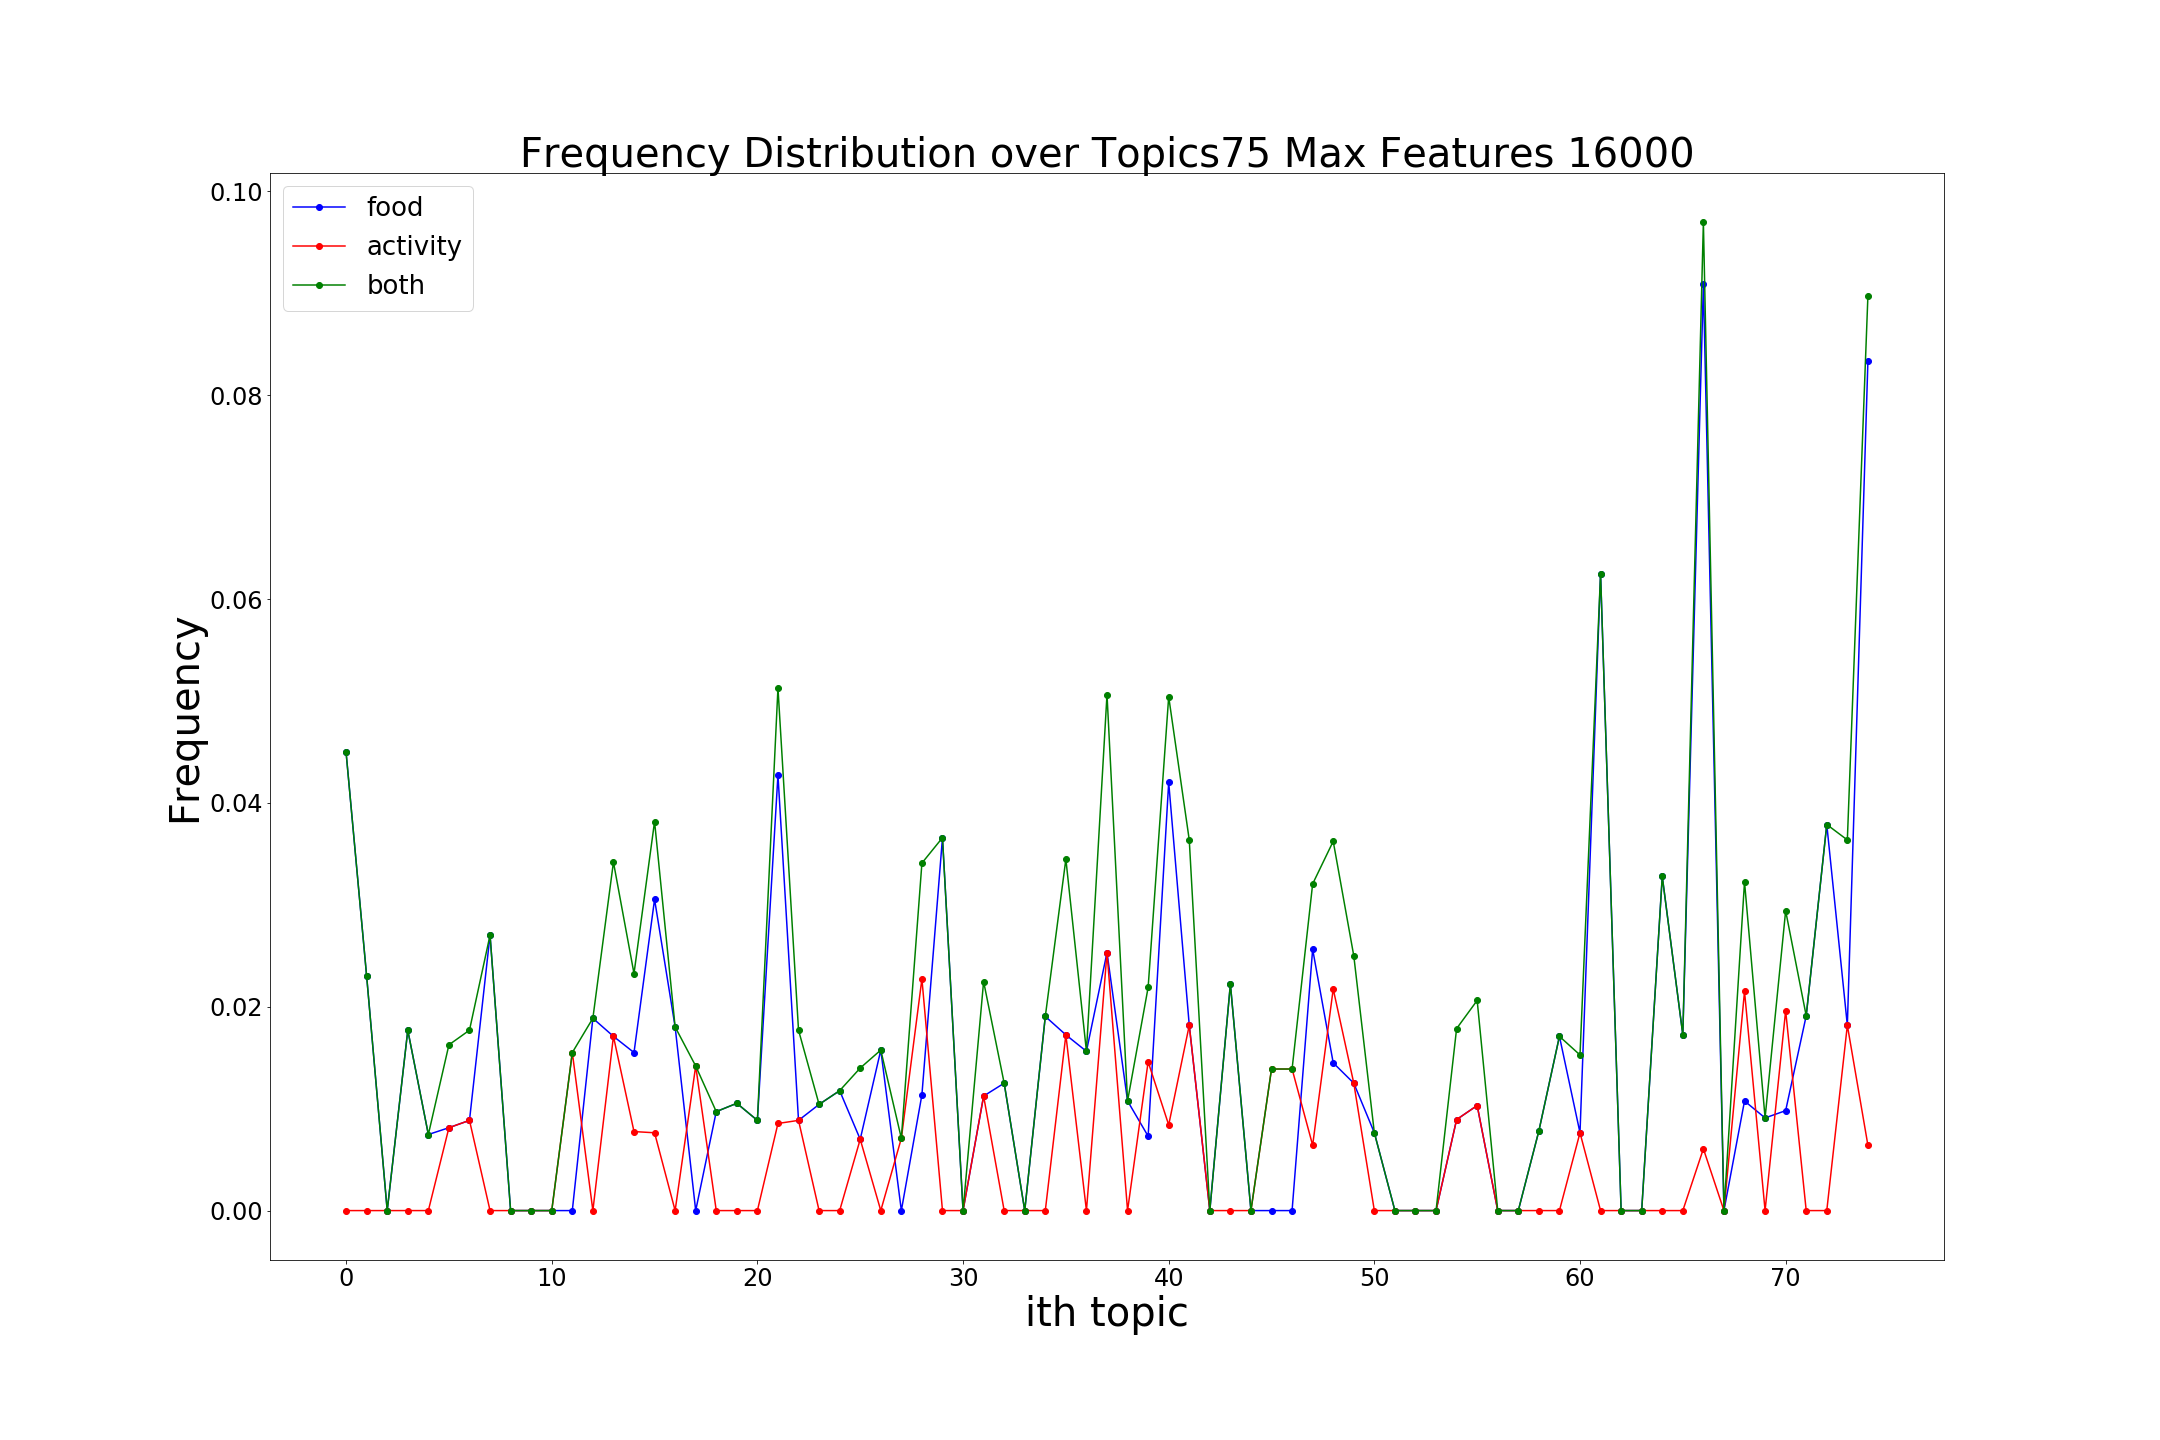

In [125]:
Image(filename='figures/topics_75_maxfeatures_16000.png')

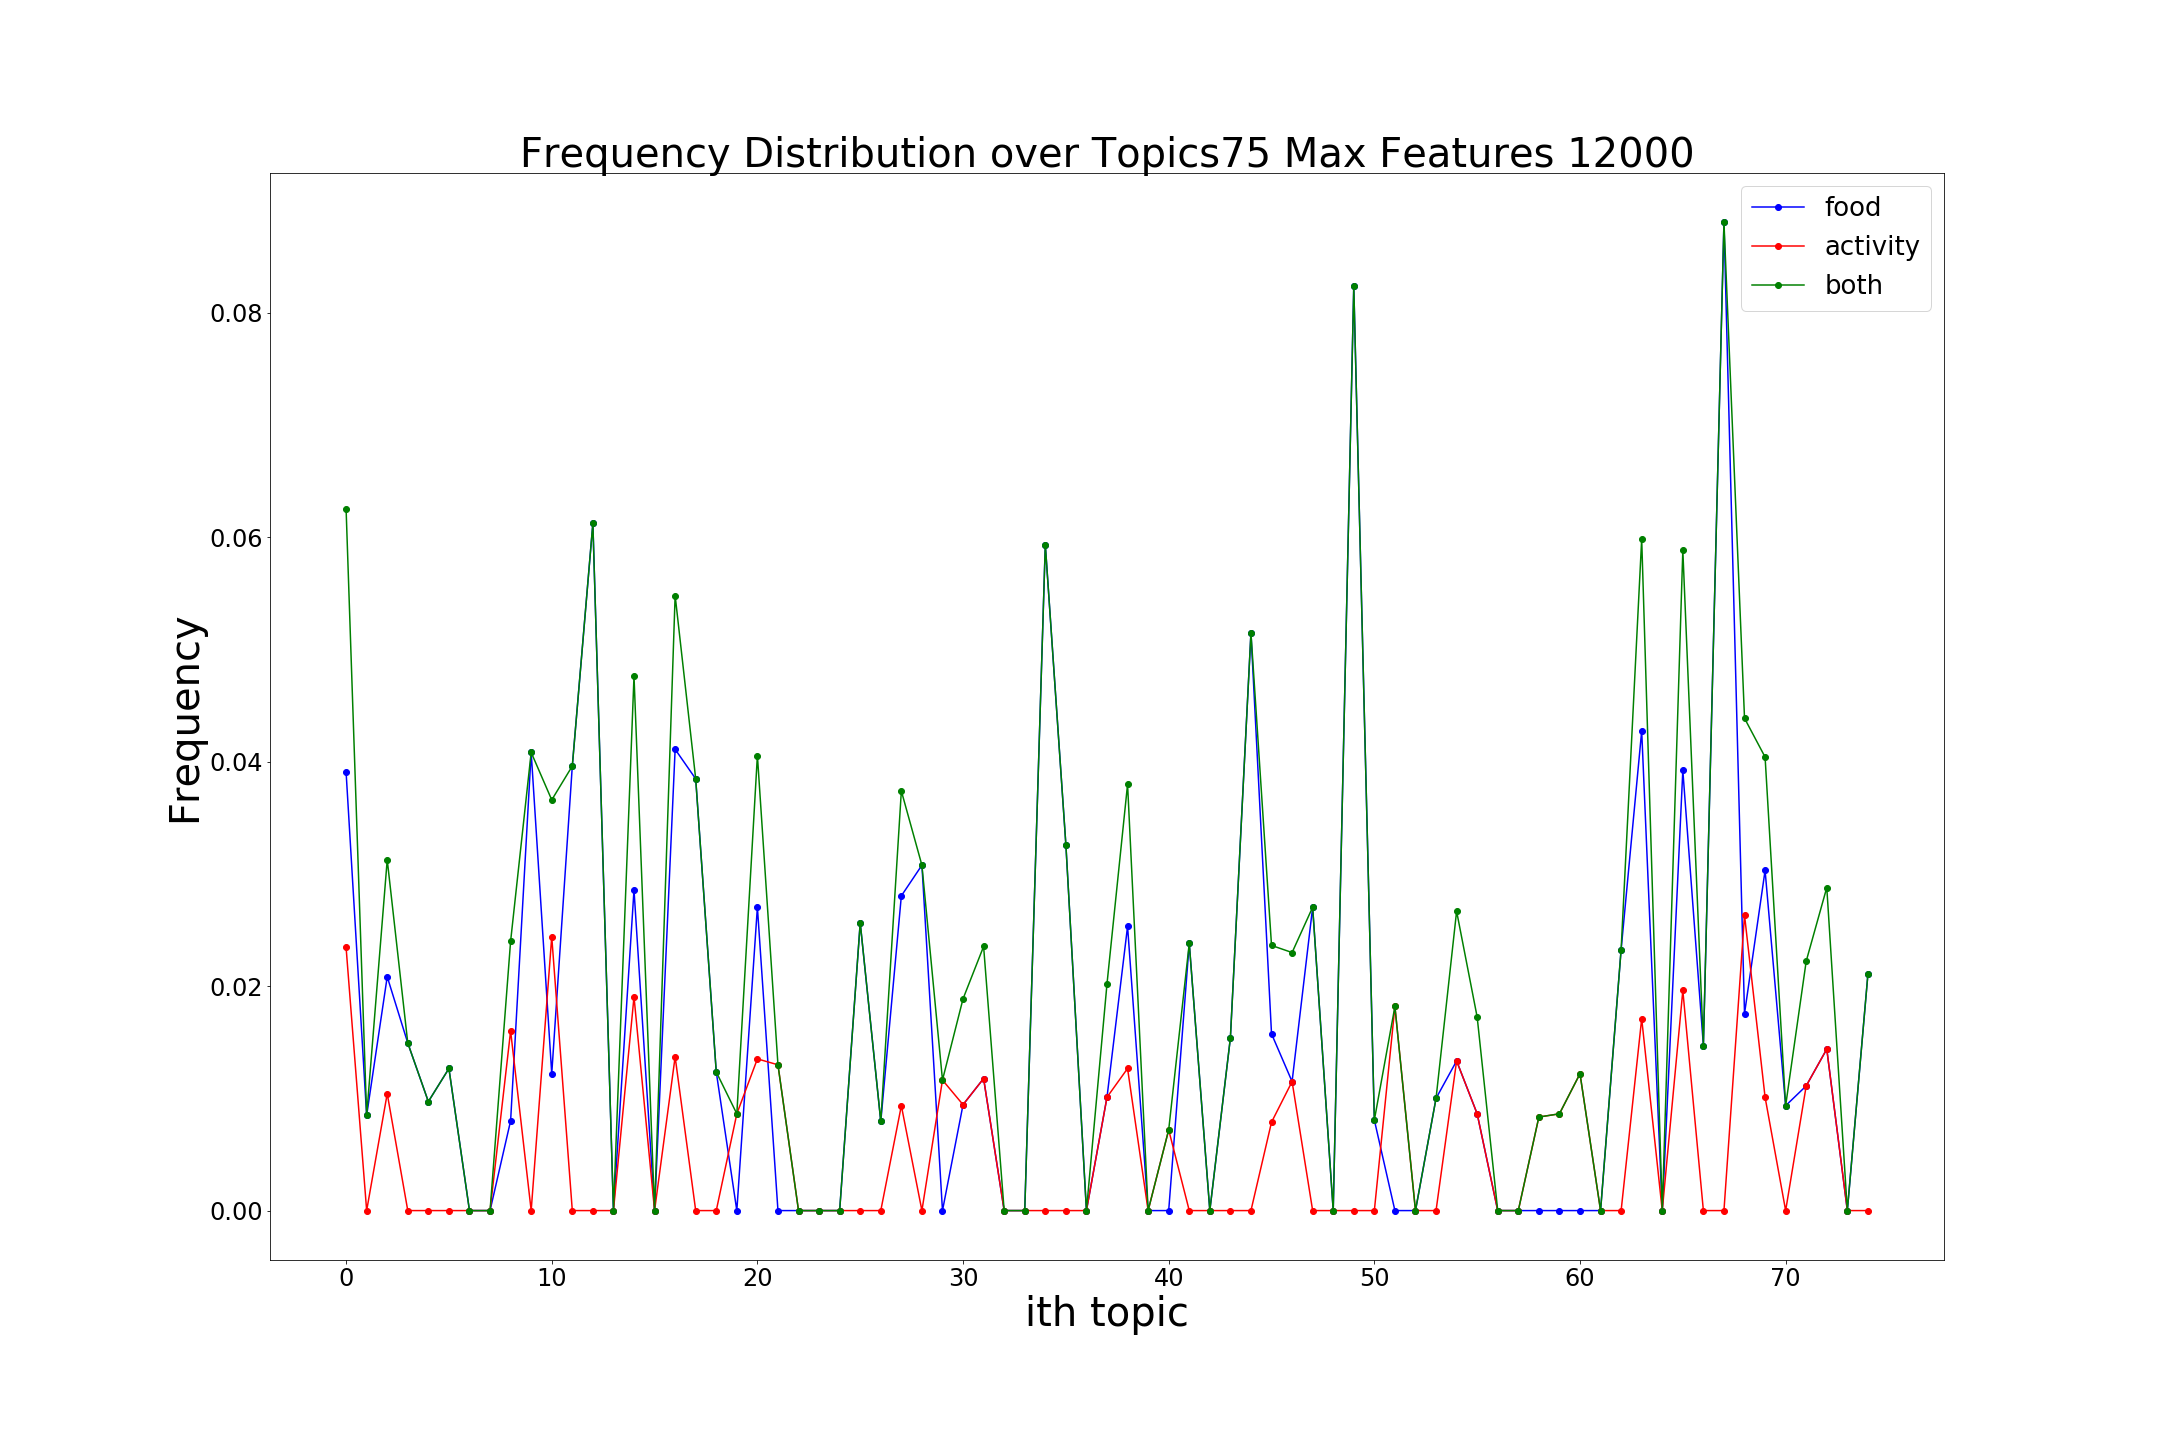

In [126]:
Image(filename='figures/topics_75_maxfeatures_12000.png')